## Model Analysis - Logistic Regression and Random Forest Neighborhood Prediction
### University of Virginia
### DS 5110: Big Data Systems
### By: TeamBike

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder\
    .master("local") \
    .appName("models") \
    .config("spark.executor.memory", '60g') \
    .config('spark.executor.cores', '10') \
    .config('spark.cores.max', '12') \
    .config("spark.driver.memory",'40g') \
    .getOrCreate()

In [4]:
%matplotlib inline

### Load models produced in previous files

In [5]:
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.classification import RandomForestClassificationModel

cvModel = CrossValidatorModel.load("lr_nbs")
rfModel = RandomForestClassificationModel.load("rf_nbs")

### Load data transformed in pipeline

In [6]:
transformed = spark.read.parquet("pipelined_data_NBs.parquet");

In [7]:
from pyspark.sql.functions import desc
import pyspark.sql.functions as F

tot = transformed.count()

transformed.groupby('start_neighborhood',).count()\
  .withColumnRenamed('count', '# Rides') \
  .withColumn('% Total', F.round((F.col('# Rides') / tot) * 100, 2) ) \
  .sort(desc("count")).show(10)

+--------------------+--------+-------+
|  start_neighborhood| # Rides|% Total|
+--------------------+--------+-------+
|   Midtown Manhattan|15825350|  32.12|
|  Downtown Manhattan| 9991879|  20.28|
|Central Park East...| 8245275|  16.73|
|          Midtown BK| 5233122|  10.62|
|           Uptown BK| 4002562|   8.12|
|    Uptown Manhattan| 3139583|   6.37|
|              Queens| 1917315|   3.89|
|         Downtown BK|  488525|   0.99|
|               Bronx|  280608|   0.57|
|Harlem & Wash. He...|  146790|    0.3|
+--------------------+--------+-------+



In [8]:
# contains stations, boroughs, and neighborhoods
station_df = spark.read.option('header',True) \
     .csv('station_df2.csv')

In [8]:
from pyspark.sql.functions import desc
import pyspark.sql.functions as F

tot = station_df.count() # num of stations

station_df.withColumnRenamed('concat', 'start_neighborhood')\
.groupby('start_neighborhood').count()\
  .withColumnRenamed('count', '# Stations') \
  .withColumn('% Total', F.round((F.col('# Stations') / tot) * 100, 2) ) \
  .sort(desc("count")).show(10)

+--------------------+----------+-------+
|  start_neighborhood|# Stations|% Total|
+--------------------+----------+-------+
|               Bronx|       226|   14.8|
|           Uptown BK|       183|  11.98|
|              Queens|       179|  11.72|
|          Midtown BK|       172|  11.26|
|   Midtown Manhattan|       171|   11.2|
|    Uptown Manhattan|       138|   9.04|
|  Downtown Manhattan|       138|   9.04|
|Central Park East...|       137|   8.97|
|         Downtown BK|       116|    7.6|
|Harlem & Wash. He...|        67|   4.39|
+--------------------+----------+-------+



### Loaded predictions from prior files

In [8]:
predictions = cvModel.transform(test_data)
predictions_rf = rfModel.transform(test_data)

### Set up evaluation metrics

In [11]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

eval_acc = MulticlassClassificationEvaluator(
    labelCol="n_index", predictionCol="prediction", metricName="accuracy")

eval_tp = MulticlassClassificationEvaluator(
    labelCol="n_index", predictionCol="prediction", metricName="truePositiveRateByLabel")

eval_fp = MulticlassClassificationEvaluator(
    labelCol="n_index", predictionCol="prediction", metricName="falsePositiveRateByLabel")

eval_prec = MulticlassClassificationEvaluator(
    labelCol="n_index", predictionCol="prediction", metricName="precisionByLabel")

eval_rec = MulticlassClassificationEvaluator(
    labelCol="n_index", predictionCol="prediction", metricName="recallByLabel")

#accuracy = evaluator.evaluate(predictions)
#print("Test Error = %g" % (1.0 - accuracy))

In [12]:
#print('true pos = %g' % eval_tp.evaluate(predictions_rf))

### Run model analyses for both models (RF and Log. Reg.)

In [13]:
print("Accurary = %g" % (eval_acc.evaluate(predictions_rf)))

Accurary = 0.632146


In [14]:
print("Accurary = %g" % (eval_acc.evaluate(predictions)))

Accurary = 0.629113


In [15]:
#print("Test Error = %g" % (1.0 - eval_acc.evaluate(predictions)))
#print('true pos = %g' % eval_tp.evaluate(predictions))

In [16]:
#eval_tp.evaluate(predictions)

In [17]:
#print('false pos = %g' % eval_fp.evaluate(predictions))

In [18]:
#eval_prec.evaluate(predictions)

In [19]:
bm = cvModel.bestModel

In [20]:
importances = rfModel.featureImportances
x_values = list(range(len(importances)))

In [21]:
#x_values

### Function pulls feature names. Source: https://www.timlrx.com/blog/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator

#### Show important features for RF model

In [22]:
import pandas as pd
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [23]:
feat_imp = ExtractFeatureImp(importances, transformed, "features").head(15)

In [24]:
#feat_imp

In [25]:
feat_imp['name'] = feat_imp['name'].str.split('encoded_').apply(lambda x: x[1])

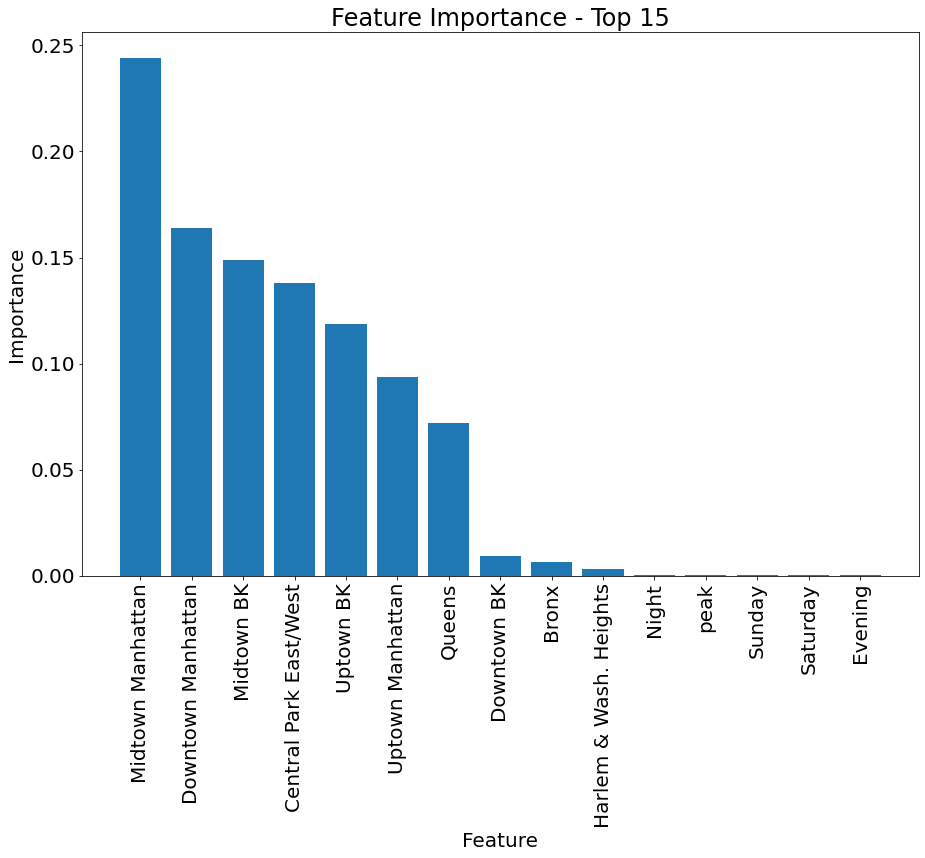

In [26]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

#plot of Feature Importance - need to work on graph look
plt.rcParams["figure.figsize"] = (15, 10)
plt.bar(feat_imp['name'], feat_imp['score'], orientation = 'vertical')
#plt.xticks(x_values, num_feat[1:], rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importance - Top 15')
plt.xticks(rotation= 90)
plt.show()

In [10]:
from pyspark.sql.functions import desc
import pyspark.sql.functions as F

tot = transformed.count()

transformed.groupby('start_neighborhood', 'end_neighborhood').count()\
  .withColumnRenamed('count', '# Rides') \
  .withColumn('% Total', F.round((F.col('# Rides') / tot) * 100, 2) ) \
  .sort(desc("count")).show(10)

+--------------------+--------------------+--------+-------+
|  start_neighborhood|    end_neighborhood| # Rides|% Total|
+--------------------+--------------------+--------+-------+
|   Midtown Manhattan|   Midtown Manhattan|10154874|  20.61|
|  Downtown Manhattan|  Downtown Manhattan| 5763571|   11.7|
|Central Park East...|Central Park East...| 4880562|   9.91|
|          Midtown BK|          Midtown BK| 3825678|   7.76|
|  Downtown Manhattan|   Midtown Manhattan| 3040322|   6.17|
|   Midtown Manhattan|  Downtown Manhattan| 3014183|   6.12|
|           Uptown BK|           Uptown BK| 2735445|   5.55|
|   Midtown Manhattan|Central Park East...| 2108910|   4.28|
|    Uptown Manhattan|    Uptown Manhattan| 1962820|   3.98|
|Central Park East...|   Midtown Manhattan| 1962534|   3.98|
+--------------------+--------------------+--------+-------+
only showing top 10 rows



In [28]:
predictions.columns

['start_neighborhood',
 'end_neighborhood',
 'day',
 'time_bin',
 'peak_commute',
 'month',
 'hour',
 'day_indexed',
 'time_bin_indexed',
 'peak_commute_indexed',
 'month_indexed',
 'start_neighborhood_indexed',
 'n_index',
 'day_indexed_encoded',
 'time_bin_indexed_encoded',
 'peak_commute_indexed_encoded',
 'month_indexed_encoded',
 'start_neighborhood_indexed_encoded',
 'label',
 'features',
 'rawPrediction',
 'probability',
 'prediction']

In [12]:
from pyspark.sql.functions import desc

tot = transformed.count()

start_end_actual = transformed.groupby('start_neighborhood', 'end_neighborhood').count()\
  .withColumn('% Tot Act', F.round((F.col('count') / tot) * 100, 2) ) #\
  #.sort(desc("count"))#.show(100)

### Prediction analysis on test data

#### Logistic Regression

In [13]:
tot = predictions.count()

predictions.where(predictions.n_index==predictions.prediction).groupby('start_neighborhood', 'end_neighborhood', 'n_index', 'prediction').count()\
  .withColumnRenamed('count', '# Rides') \
  .withColumn('% Total', F.round((F.col('# Rides') / tot) * 100, 2) ) \
  .join(start_end_actual, on = ['start_neighborhood', 'end_neighborhood'], how = 'left')\
  .withColumnRenamed('count', '# Rides Act').sort(desc("count"))\
  .drop('n_index', 'prediction', '# Rides', '# Rides Act').show(20)

+--------------------+--------------------+-------+---------+
|  start_neighborhood|    end_neighborhood|% Total|% Tot Act|
+--------------------+--------------------+-------+---------+
|   Midtown Manhattan|   Midtown Manhattan|  20.61|    20.61|
|  Downtown Manhattan|  Downtown Manhattan|   11.7|     11.7|
|Central Park East...|Central Park East...|    9.9|     9.91|
|          Midtown BK|          Midtown BK|   7.76|     7.76|
|           Uptown BK|           Uptown BK|   5.54|     5.55|
|    Uptown Manhattan|    Uptown Manhattan|   3.99|     3.98|
|              Queens|              Queens|   2.86|     2.86|
|         Downtown BK|          Midtown BK|   0.53|     0.53|
|              Queens|   Midtown Manhattan|    0.0|     0.12|
|Harlem & Wash. He...|   Midtown Manhattan|   0.01|     0.01|
|               Bronx|   Midtown Manhattan|   0.01|     0.01|
+--------------------+--------------------+-------+---------+



#### Random Forest

In [14]:
tot = predictions_rf.count()

predictions_rf.where(predictions_rf.n_index==predictions_rf.prediction).groupby('start_neighborhood', 'end_neighborhood', 'n_index', 'prediction').count()\
  .withColumnRenamed('count', '# Rides') \
  .withColumn('% Total', F.round((F.col('# Rides') / tot) * 100, 2) ) \
  .join(start_end_actual, on = ['start_neighborhood', 'end_neighborhood'], how = 'left')\
  .withColumnRenamed('count', '# Rides Act').sort(desc("count"))\
  .drop('n_index', 'prediction', '# Rides', '# Rides Act').show(20)

+--------------------+--------------------+-------+---------+
|  start_neighborhood|    end_neighborhood|% Total|% Tot Act|
+--------------------+--------------------+-------+---------+
|   Midtown Manhattan|   Midtown Manhattan|  20.61|    20.61|
|  Downtown Manhattan|  Downtown Manhattan|   11.7|     11.7|
|Central Park East...|Central Park East...|    9.9|     9.91|
|          Midtown BK|          Midtown BK|   7.76|     7.76|
|           Uptown BK|           Uptown BK|   5.54|     5.55|
|    Uptown Manhattan|    Uptown Manhattan|   3.99|     3.98|
|              Queens|              Queens|   2.86|     2.86|
|         Downtown BK|          Midtown BK|   0.53|     0.53|
|               Bronx|               Bronx|   0.29|     0.43|
|Harlem & Wash. He...|    Uptown Manhattan|   0.02|      0.1|
|Harlem & Wash. He...|Central Park East...|    0.0|     0.04|
|Harlem & Wash. He...|   Midtown Manhattan|   0.01|     0.01|
|               Bronx|   Midtown Manhattan|    0.0|     0.01|
+-------

#### Logistic Regression

In [15]:
tot = predictions.count()

predictions.where(predictions.n_index!=predictions.prediction).groupby('start_neighborhood', 'end_neighborhood', 'n_index', 'prediction').count()\
  .withColumnRenamed('count', '# Rides') \
  .withColumn('% Total', F.round((F.col('# Rides') / tot) * 100, 2) ) \
  .join(start_end_actual, on = ['start_neighborhood', 'end_neighborhood'], how = 'left')\
  .withColumnRenamed('count', '# Rides Act').sort(desc("count"))\
  .drop('n_index', 'prediction', '# Rides', '# Rides Act').show(20)

+--------------------+--------------------+-------+---------+
|  start_neighborhood|    end_neighborhood|% Total|% Tot Act|
+--------------------+--------------------+-------+---------+
|  Downtown Manhattan|   Midtown Manhattan|   6.17|     6.17|
|   Midtown Manhattan|  Downtown Manhattan|   6.13|     6.12|
|   Midtown Manhattan|Central Park East...|   4.27|     4.28|
|Central Park East...|   Midtown Manhattan|   3.99|     3.98|
|              Queens|              Queens|    0.0|     2.86|
|    Uptown Manhattan|Central Park East...|   1.73|     1.73|
|Central Park East...|    Uptown Manhattan|   1.71|     1.71|
|           Uptown BK|          Midtown BK|   1.12|     1.12|
|          Midtown BK|           Uptown BK|   1.03|     1.03|
|  Downtown Manhattan|          Midtown BK|   0.87|     0.87|
|          Midtown BK|  Downtown Manhattan|   0.77|     0.77|
|  Downtown Manhattan|Central Park East...|   0.75|     0.75|
|Central Park East...|  Downtown Manhattan|   0.73|     0.74|
|       

#### Random Forest

In [16]:
import pyspark.sql.functions as F

tot = predictions_rf.count()

predictions_rf.where(predictions_rf.n_index!=predictions_rf.prediction).groupby('start_neighborhood', 'end_neighborhood', 'n_index', 'prediction').count()\
  .withColumnRenamed('count', '# Rides') \
  .withColumn('% Total', F.round((F.col('# Rides') / tot) * 100, 2) ) \
  .join(start_end_actual, on = ['start_neighborhood', 'end_neighborhood'], how = 'left')\
  .withColumnRenamed('count', '# Rides Act').sort(desc("count"))\
  .drop('n_index', 'prediction', '# Rides', '# Rides Act').show(20)

+--------------------+--------------------+-------+---------+
|  start_neighborhood|    end_neighborhood|% Total|% Tot Act|
+--------------------+--------------------+-------+---------+
|  Downtown Manhattan|   Midtown Manhattan|   6.17|     6.17|
|   Midtown Manhattan|  Downtown Manhattan|   6.13|     6.12|
|   Midtown Manhattan|Central Park East...|   4.27|     4.28|
|Central Park East...|   Midtown Manhattan|   3.99|     3.98|
|    Uptown Manhattan|Central Park East...|   1.73|     1.73|
|Central Park East...|    Uptown Manhattan|   1.71|     1.71|
|           Uptown BK|          Midtown BK|   1.12|     1.12|
|          Midtown BK|           Uptown BK|   1.03|     1.03|
|  Downtown Manhattan|          Midtown BK|   0.87|     0.87|
|          Midtown BK|  Downtown Manhattan|   0.77|     0.77|
|  Downtown Manhattan|Central Park East...|   0.75|     0.75|
|Central Park East...|  Downtown Manhattan|   0.73|     0.74|
|          Midtown BK|         Downtown BK|   0.68|     0.68|
|  Downt

In [17]:
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = predictions_rf.select(['prediction','n_index']).withColumn('label', F.col('n_index').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

#metrics.precision()


In [18]:
predictions.show(2)

+------------------+----------------+------+---------+------------+-----+----+-----------+----------------+--------------------+-------------+--------------------------+-------+-------------------+------------------------+----------------------------+---------------------+----------------------------------+-------------+--------------------+--------------------+--------------------+----------+
|start_neighborhood|end_neighborhood|   day| time_bin|peak_commute|month|hour|day_indexed|time_bin_indexed|peak_commute_indexed|month_indexed|start_neighborhood_indexed|n_index|day_indexed_encoded|time_bin_indexed_encoded|peak_commute_indexed_encoded|month_indexed_encoded|start_neighborhood_indexed_encoded|        label|            features|       rawPrediction|         probability|prediction|
+------------------+----------------+------+---------+------------+-----+----+-----------+----------------+--------------------+-------------+--------------------------+-------+-------------------+---------

In [19]:
print(metrics.confusionMatrix())#.toArray())

DenseMatrix([[3.048257e+06, 9.120190e+05, 5.897390e+05, 4.420200e+04,
              4.319300e+04, 5.490100e+04, 1.729100e+04, 0.000000e+00,
              5.580000e+02, 0.000000e+00],
             [9.061030e+05, 1.730010e+06, 1.084600e+05, 1.235570e+05,
              8.724900e+04, 1.155300e+04, 5.428000e+03, 0.000000e+00,
              1.560000e+02, 0.000000e+00],
             [6.376680e+05, 1.103680e+05, 1.464282e+06, 7.146000e+03,
              9.955000e+03, 2.564270e+05, 3.821900e+04, 0.000000e+00,
              1.866000e+03, 0.000000e+00],
             [4.479300e+04, 1.285420e+05, 6.867000e+03, 1.225355e+06,
              1.653190e+05, 6.910000e+02, 8.938000e+03, 0.000000e+00,
              2.900000e+01, 0.000000e+00],
             [4.225300e+04, 9.470600e+04, 9.582000e+03, 1.558180e+05,
              8.196850e+05, 8.640000e+02, 7.664500e+04, 0.000000e+00,
              3.900000e+01, 0.000000e+00],
             [7.268400e+04, 1.008600e+04, 2.534320e+05, 6.600000e+02,
              9

### Confusion Matrix provides little utility here with so many classes

In [20]:
metrics.precision(0)

0.6332147125254391

In [21]:
#labels = predictions.select('n_index', 'end_neighborhood', 'start_neighborhood_indexed', 'start_neighborhood').distinct().rdd.collect()
labels = predictions.select('n_index', 'end_neighborhood').distinct().rdd.collect()

### Show precision for each end neighborhood for random forest

In [22]:
print('Label Precisions by Ending Neighborhood')
for l in labels:
    print(l[1], 'prec:', metrics.precision(l[0]))

Label Precisions by Ending Neighborhood
Bronx prec: 0.7586366467918484
Harlem & Wash. Heights prec: 0.0
Downtown Manhattan prec: 0.5770202512925345
Central Park East/West prec: 0.5917266361485045
Downtown BK prec: 0.0
Midtown Manhattan prec: 0.6332147125254391
Queens prec: 0.7361960736580362
Uptown BK prec: 0.6827994205636593
Midtown BK prec: 0.714109632150683
Uptown Manhattan prec: 0.6234574080767484


### Show true-positive rate for each end neighborhood for random forest

In [23]:
print('Label True Pos by Ending Neighborhood')
for l in labels:
    print('NB =', l[1], metrics.truePositiveRate(l[0]))

Label True Pos by Ending Neighborhood
NB = Bronx 0.5078275788119236
NB = Harlem & Wash. Heights 0.0
NB = Downtown Manhattan 0.5820019135304907
NB = Central Park East/West 0.5796999205441479
NB = Downtown BK 0.0
NB = Midtown Manhattan 0.6471663382984867
NB = Queens 0.7529736286094374
NB = Uptown BK 0.6833031564065115
NB = Midtown BK 0.7752791145271155
NB = Uptown Manhattan 0.6278405171773425


### Show false-positive rate for each end neighborhood for random forest

In [24]:
print('Label False Pos by Ending Neighborhood')
for l in labels:
    print('NB =', l[1], metrics.falsePositiveRate(l[0]))

Label False Pos by Ending Neighborhood
NB = Bronx 0.0009225534696303303
NB = Harlem & Wash. Heights 0.0
NB = Downtown Manhattan 0.10737333857033164
NB = Central Park East/West 0.08242434665299114
NB = Downtown BK 0.0
NB = Midtown Manhattan 0.17528523478106695
NB = Queens 0.010668038714648687
NB = Uptown BK 0.0280328842652635
NB = Midtown BK 0.03715608007653517
NB = Uptown Manhattan 0.02581661868966615
